In [3]:
import qutip as qt
import numpy as np

In [4]:
def operator_2level_trunc(op, states):
    g, e = states
    return qt.Qobj(
        np.array([
            [g.dag() * op * g, g.dag() * op * e],
            [e.dag() * op * g, e.dag() * op * e]
        ], dtype=complex),
        dims=[[2], [2]]
    )

In [5]:
def hamiltonian_qt(ECT, ECR, ECoup, EJ, EL, transmon_trunc=31, resonator_trunc=40):
    
    
    
    ## Transmon Hamiltonian
    charge = qt.charge(transmon_trunc // 2, -transmon_trunc // 2)
    cos_phi = qt.tunneling(2 * transmon_trunc // 2 + 1)
    HT = 4 * ECT * charge * charge - EJ / 2 * cos_phi

    _, Evecs = HT.eigenstates()
    g, e = Evecs[0], Evecs[1]

    HT_2dim = operator_2level_trunc(HT, [g,e])
    charge_2dim = operator_2level_trunc(charge, [g,e])



    ## Resonator Hamiltonian
    creation = qt.create(resonator_trunc)  
    destruction = qt.destroy(resonator_trunc)

    HR = np.sqrt(8 * ECR * EL) * (creation * destruction + 1 / 2)



    ## Coupling Hamiltonian
    phizpf = ((2 * ECR) / EL) ** (1 / 4)
    n_R = (destruction - creation) / (2j * phizpf)

    HC = -4 * ECoup * qt.tensor(charge_2dim, n_R)



    ## Final Hamiltonian :
    return (
        qt.tensor(HT_2dim, qt.qeye(resonator_trunc))
        + qt.tensor(qt.qeye(2), HR)
        + HC
    )

In [11]:
def find_state_match_index(Product_state_ind, True_evecs, resonator_trunc) : 
    
    product_state = qt.tensor(qt.basis(2,Product_state_ind[0]),qt.basis(resonator_trunc,Product_state_ind[1]))

    best_ind = 0
    best_val = 0

    i=0

    for i, psi in enumerate(True_evecs):

        scalar_prod = abs(psi.overlap(product_state))

        if best_val < scalar_prod :
            best_ind = i
            best_val = scalar_prod

        i += 1

    return best_ind


The equation :

$$
H_{approx} \approx \hbar(\omega_r + \chi\hat\sigma_z)\hat a^{\dagger} \hat a + \frac {\hbar \omega_q} 2 \hat\sigma_z
$$

In [35]:
def find_chi(ECT, ECR, ECoup, EJ, EL, transmon_trunc=31, resonator_trunc=40):

    H = hamiltonian_qt(ECT, ECR, ECoup, EJ, EL, transmon_trunc, resonator_trunc)

    Evals, Evecs = H.eigenstates()

    omegaq = Evals[find_state_match_index([1,0], Evecs, resonator_trunc)] - Evals[find_state_match_index([0,0], Evecs, resonator_trunc)]
    omegaq_plus_2chi = Evals[find_state_match_index([1,1], Evecs, resonator_trunc)] - Evals[find_state_match_index([0,1], Evecs, resonator_trunc)]

    return 1/2 *( omegaq_plus_2chi - omegaq )

Remember that we had : 
$$E_{coupling} := e^2 \frac{C_C}{C_T C_R}$$
And 
$$g = -4E_{coupling}$$ $$\Delta = |\omega_q-\omega_r|$$

# Plotting the results

We would like to plot $\chi$ as a function of $\frac g {\Delta}$. We will have g fixed here and change $\Delta$ through $\omega_r$, or rather through $E_L$

In [31]:
import matplotlib.pyplot as plt

The analytical expression of this $\chi$ is :
$$
\chi = - \frac {g^2} {\Delta}
$$

Where :
- $g$ is the coupling strength
- $\Delta$ the qubit-resonator detuning

In [46]:
def chi_analytical(Delta,g):
    return -g**2 / (Delta)

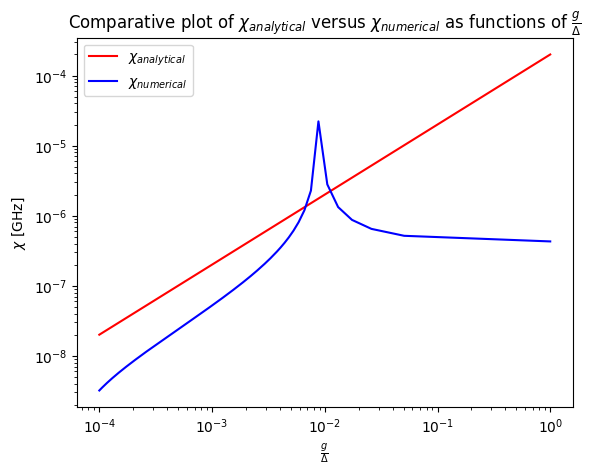

In [56]:
ECT = 0.5
ECR = 0.5
EJ = 5
ECoup = 5e-5

g = 4*ECoup

omega_q = np.sqrt(8 * EJ * ECT) - ECT

EL_list = np.linspace(1/(8*ECR) * (omega_q-g)**2, 1/(8*ECR) * (omega_q - 10000*g)**2,400)

Chi_numerical = []
Chi_analytical = []
G_over_delta = []

for EL in EL_list :

       Chi_numerical.append(find_chi(ECT, ECR, ECoup, EJ, EL, resonator_trunc=20))
              
       omega_r = np.sqrt(8 * ECR * EL)

       Delta = omega_q - omega_r

       Chi_analytical.append(chi_analytical(Delta, g))
       G_over_delta.append(abs(g / Delta))

fig, ax = plt.subplots()

@np.vectorize
def divide(a,b):
       return a/b

ax.plot(G_over_delta, np.abs(Chi_analytical), c='r')
ax.plot(G_over_delta, np.abs(Chi_numerical), c='b')
ax.legend([r'$\chi_{analytical}$',r'$\chi_{numerical}$'])
ax.set(xlabel=r'$\frac {g} {\Delta}$',
       ylabel=r'$\chi$ [GHz]',
       title =r'Comparative plot of $\chi_{analytical}$ versus $\chi_{numerical}$ as functions of $\frac {g} {\Delta}$',
       xscale = 'log',
       yscale = 'log')

plt.show()
